In [1]:
%matplotlib inline


Group analysis of resting-state fMRI with ICA: CanICA
=====================================================

An example applying CanICA to resting-state data. This example applies it
to 30 subjects of the ADHD200 datasets. Then it plots a map with all the
components together and an axial cut for each of the components separately.

CanICA is an ICA method for group-level analysis of fMRI data. Compared
to other strategies, it brings a well-controlled group model, as well as a
thresholding algorithm controlling for specificity and sensitivity with
an explicit model of the signal. The reference papers are:

    * G. Varoquaux et al. "A group model for stable multi-subject ICA on
      fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299

    * G. Varoquaux et al. "ICA-based sparse features recovery from fMRI
      datasets", IEEE ISBI 2010, p. 1177

Pre-prints for both papers are available on hal
(http://hal.archives-ouvertes.fr)

<div class="alert alert-info"><h4>Note</h4><p>The use of the attribute `components_img_` from decomposition
    estimators is implemented from version 0.4.1.
    For older versions, unmask the deprecated attribute `components_`
    to get the components image using attribute `masker_` embedded in
    estimator.
    See the `section Inverse transform: unmasking data <unmasking_step>`.</p></div>



First we load the ADHD200 data
-------------------------------



In [2]:
from nilearn import datasets

adhd_dataset = datasets.fetch_adhd(n_subjects=1)
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

First functional nifti image (4D) is at: /home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


/home/uga_qinglin/Documents/nilearn-deep/nilearn/datasets/func.py:502: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


Here we apply CanICA on the data
---------------------------------



In [3]:
from nilearn.decomposition import CanICA

canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
data=canica.prepare_data(func_filenames)
print(data.shape)
canica.fit(data)
# Retrieve the independent components in brain space. Directly
# accesible through attribute `components_img_`. Note that this
# attribute is implemented from version 0.4.1. For older versions,
# see note section above for details.
components_img = canica.components_img_
# components_img is a Nifti Image object, and can be saved to a file with
# the following line:
components_img.to_filename('canica_resting_state.nii.gz')

[MultiNiftiMasker.fit] Loading data from [/home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz]
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
(20, 62546)
[Memory]0.0s, 0.0min    : Loading randomized_svd from nilearn_cache/joblib/sklearn/utils/extmath/randomized_svd/aefe6e364d4355a6a5741767cc44860c
______________________________________randomized_svd cache loaded - 0.0s, 0.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s


[Memory]0.1s, 0.0min    : Loading fastica from nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/7a10b1cefbfe79bcd4d85e0adcb777d1
_____________________________________________fastica cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading fastica from nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/095b5fdbae74de2ef643e843d642bf7a
_____________________________________________fastica cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading fastica from nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/8f95d2197edbd90f44d51ee817e872ac
_____________________________________________fastica cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading fastica from nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/c91dd94af1ce2eb668baf34c150eefbf
_____________________________________________fastica cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading fastica from nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/ad300c2fa

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Memory]0.3s, 0.0min    : Loading fastica from nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/87b5ef9f7ce30132881a9be4c72f797d
_____________________________________________fastica cache loaded - 0.0s, 0.0min


In [4]:
data.type()

AttributeError: 'numpy.ndarray' object has no attribute 'type'

To visualize we plot the outline of all components on one figure
-----------------------------------------------------------------



/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:946: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


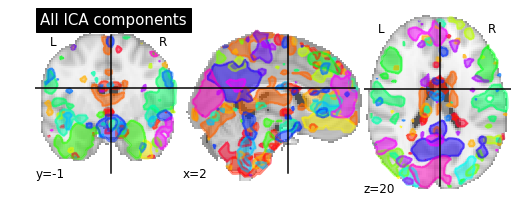

In [5]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')

Finally, we plot the map for each ICA component separately
-----------------------------------------------------------



In [ ]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)

show()

In [ ]:
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

In [ ]:
from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

# Mean of all correlations
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)

In [ ]:
# ----------------------------

title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)

# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title)